<a href="https://colab.research.google.com/github/hamzi27/adv-ml-assignment1/blob/master/ass1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amrani Hamza - 807386

# Load data

In [1]:
import pandas as pd
import numpy as np

url_train = 'https://raw.githubusercontent.com/hamzi27/adv-ml-assignment1/master/train.csv'
url_test = 'https://raw.githubusercontent.com/hamzi27/adv-ml-assignment1/master/test.csv'

train = pd.read_csv(url_train)
test = pd.read_csv(url_test)

print(train.head())
print("Training set data shape: ", train.shape)

   LIMIT_BAL  SEX  EDUCATION  ...  PAY_AMT5  PAY_AMT6  default.payment.next.month
0    20000.0    2          2  ...       0.0       0.0                           1
1   120000.0    2          2  ...       0.0    2000.0                           1
2    90000.0    2          2  ...    1000.0    5000.0                           0
3    50000.0    2          2  ...    1069.0    1000.0                           0
4    50000.0    1          2  ...     689.0     679.0                           0

[5 rows x 24 columns]
Training set data shape:  (27000, 24)


# Analysis on data

In [0]:
# !pip install -U pandas_profiling

In [0]:
#import pandas_profiling

# train.profile_report(style={'full_width':True})


# Removing columns highly correlated and duplicates rows

In [3]:
# Drop of duplicates rows
train = train.drop_duplicates()
test = test.drop_duplicates()

# Drop columns lowly correlated to target

train.drop(columns=['AGE','EDUCATION','LIMIT_BAL','MARRIAGE','SEX','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6'], axis=1, inplace=True)
test.drop(columns=['AGE','EDUCATION','LIMIT_BAL','MARRIAGE','SEX','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6'], axis=1, inplace=True)

print("Train shape: ", train.shape)
print("Number of 0: ", sum(train['default.payment.next.month']==0))
print("Number of 1: ", sum(train['default.payment.next.month']==1))

Train shape:  (26973, 13)
Number of 0:  21004
Number of 1:  5969


# Split train

In [4]:
from sklearn.model_selection import train_test_split

train, validation = train_test_split( train,test_size=0.2)

print("Train: ", train.shape)

num_0 = sum(train['default.payment.next.month']==0)
num_1 = sum(train['default.payment.next.month']==1)
print("Number of 0: ", num_0)
print("Number of 1: ", num_1)

print("\nValidation: ", validation.shape)
print("Number of 0: ", sum(validation['default.payment.next.month']==0))
print("Number of 1: ", sum(validation['default.payment.next.month']==1))

Train:  (21578, 13)
Number of 0:  16756
Number of 1:  4822

Validation:  (5395, 13)
Number of 0:  4248
Number of 1:  1147


# Over-sample data

In [5]:
from numpy.random import random_sample

train_1 = train[train['default.payment.next.month']==1]

values = [train_1[column].value_counts(normalize=True).keys().tolist() for column in train_1.columns[:-1]]
probabilities = [train_1[column].value_counts(normalize=True).tolist() for column in train_1.columns[:-1]]

verify = {}
for index, row in train_1.iterrows():
    verify [str(row.values)]=1
    
sample_rows = []
for _ in range(num_0-num_1):
  while True:
    sample_row = []
    
    for i in range(len(values)):
      bins = np.add.accumulate(probabilities[i])
      sample_of_column = [values[i][n] for n in np.digitize(random_sample(1), bins)]
      sample_row.extend(sample_of_column)
    sample_row.extend([1])
    
    try:
      verify[str(sample_row)]
    except:
      verify[str(sample_row)] = 1
      break
  
  sample_rows.append(sample_row)

train_oversample = pd.DataFrame(sample_rows, columns = train.columns) 
train = train.append(train_oversample, ignore_index=True)

print(train.head())

print("Ended over-sample on train!")
print("Number of 0: ", sum(train['default.payment.next.month']==0))
print("Number of 1: ", sum(train['default.payment.next.month']==1))



   PAY_0  PAY_2  PAY_3  ...  PAY_AMT5  PAY_AMT6  default.payment.next.month
0     -1     -1     -1  ...       0.0    1593.0                           0
1      0      0      0  ...    5155.0    4145.0                           0
2      2      2      0  ...   13600.0   13600.0                           1
3      0     -1      0  ...    9000.0    9014.0                           0
4      0      0      0  ...       0.0    5000.0                           0

[5 rows x 13 columns]
Ended over-sample on train!
Number of 0:  16756
Number of 1:  16756


# Standardization

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

def load_data(df, train=True):
    X = df.values.copy()
    if train:
        np.random.shuffle(X)  
        X, labels = X[:, 0:-1].astype(np.float32), X[:, -1]
        return X, labels
    else:
        X, ids = X[:, 0:].astype(np.float32), X[:, 0].astype(str)
        return X, ids


def preprocess_labels(labels, encoder=None, categorical=True):
    """Encode labels with values among 0 and `n-classes-1`"""
    if not encoder:
        encoder = LabelEncoder()
        encoder.fit(labels)
    y = encoder.transform(labels).astype(np.int32)
    if categorical:
        y = np_utils.to_categorical(y)
    return y, encoder
  

X_train, Y_train = load_data(train, train=True)
X_val, Y_val = load_data(validation, train=True)
X_test, Y_test = load_data(test, train=False)
  
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


Y_train, encoder = preprocess_labels(Y_train)
Y_val, encoder_val = preprocess_labels(Y_val)

nb_classes = Y_train.shape[1]
dims = X_train.shape[1]

print(nb_classes, 'classes')
print(dims, 'dims')

Using TensorFlow backend.


2 classes
12 dims


# Neural Network

In [7]:
pip install keras_metrics

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.core import Activation, Dropout
import keras_metrics

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(dims,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
          
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics =["accuracy", keras_metrics.binary_precision(), keras_metrics.binary_recall(), keras_metrics.binary_f1_score()])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 64)                832       
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 66        
_________________________________________________________________
activation_5 (Activation)    (None, 2)                 0         
Total params: 2,978
Trainable params: 2,978
Non-trainable params: 0
_________________________________________________________________


In [32]:
hist = model.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=True) 


Train on 26809 samples, validate on 6703 samples
Epoch 1/100
26809/26809 [==============================] - 1s 27us/step - loss: 0.6261 - acc: 0.7155 - precision: 0.7130 - recall: 0.7253 - f1_score: 0.7191 - val_loss: 0.5829 - val_acc: 0.7676 - val_precision: 0.7554 - val_recall: 0.7793 - val_f1_score: 0.7672
Epoch 2/100
26809/26809 [==============================] - 0s 16us/step - loss: 0.5466 - acc: 0.7911 - precision: 0.7868 - recall: 0.8011 - f1_score: 0.7939 - val_loss: 0.5389 - val_acc: 0.7856 - val_precision: 0.7720 - val_recall: 0.7999 - val_f1_score: 0.7857
Epoch 3/100
26809/26809 [==============================] - 0s 15us/step - loss: 0.5078 - acc: 0.8003 - precision: 0.7962 - recall: 0.8093 - f1_score: 0.8027 - val_loss: 0.5098 - val_acc: 0.7913 - val_precision: 0.7829 - val_recall: 0.7960 - val_f1_score: 0.7894
Epoch 4/100
26809/26809 [==============================] - 0s 15us/step - loss: 0.4806 - acc: 0.8047 - precision: 0.8049 - recall: 0.8065 - f1_score: 0.8057 - val_lo

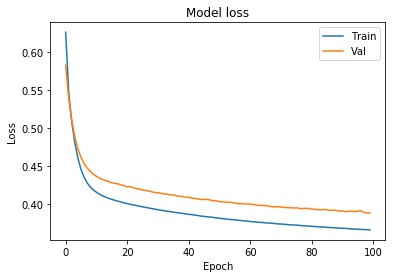

In [33]:
# Plot model loss

import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

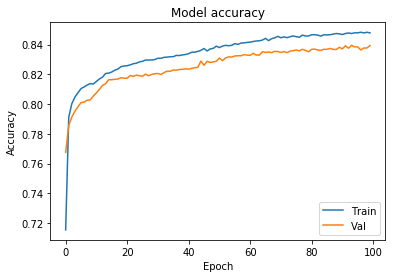

In [34]:
# Plot model acuracy

import matplotlib.pyplot as plt

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [37]:
results = model.evaluate(X_val, Y_val)

print('test loss, test acc:', results)

5395/5395 [==============================] - 0s 26us/step
test loss, test acc: [0.48881267818507496, 0.7933271547176973, 0.8647264260567002, 0.8742937852901532, 0.8694837378776843]


In [38]:
from sklearn.metrics import classification_report, confusion_matrix

Y_val_true = [ enc[int(max(enc))] for enc in Y_val]

print( 'Classification report\n', classification_report(Y_val_true, model.predict_classes(X_val)) )

Classification report
               precision    recall  f1-score   support

         0.0       0.86      0.87      0.87      4248
         1.0       0.51      0.49      0.50      1147

    accuracy                           0.79      5395
   macro avg       0.69      0.68      0.69      5395
weighted avg       0.79      0.79      0.79      5395



In [40]:
# Predict on test

Y_test_pred = model.predict_classes(X_test)
print(Y_test_pred)

with open("test_pred.txt", "w") as txt_file:
    for line in Y_test_pred:
        txt_file.write(str(line) + "\n") # works with any number of elements in

[0 0 0 ... 1 0 0]
